In [3]:
from quasinet.qnet import load_qnet, qdistance, qdistance_matrix
from quasinet.utils import numparameters
from quasinet.qsampling import qsample
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [4]:
model=load_qnet('./LSM.gz')
numparameters(model)

(np.int64(2485908), np.float64(40.027453390698625))

In [5]:
#! rm treesRAND2016/*.dot treesRAND2016/*.png
#! scp -r treesRAND2016 ishanu@34.66.189.202:/var/www/html/data

In [6]:
df=pd.read_csv('./cleaneddf.csv',index_col=0,keep_default_na=False)[model.feature_names]
df_test=df.tail(4972).sample(1000)

In [7]:
X=df_test.values.astype(str)

In [8]:
%%time
# generate and visualize LSM distanec matrix between 100 random samples
N=500
H=qdistance_matrix(X[:N],X[:N],model,model)

symmetric case
CPU times: user 45min 39s, sys: 6.95 s, total: 45min 46s
Wall time: 20min 46s


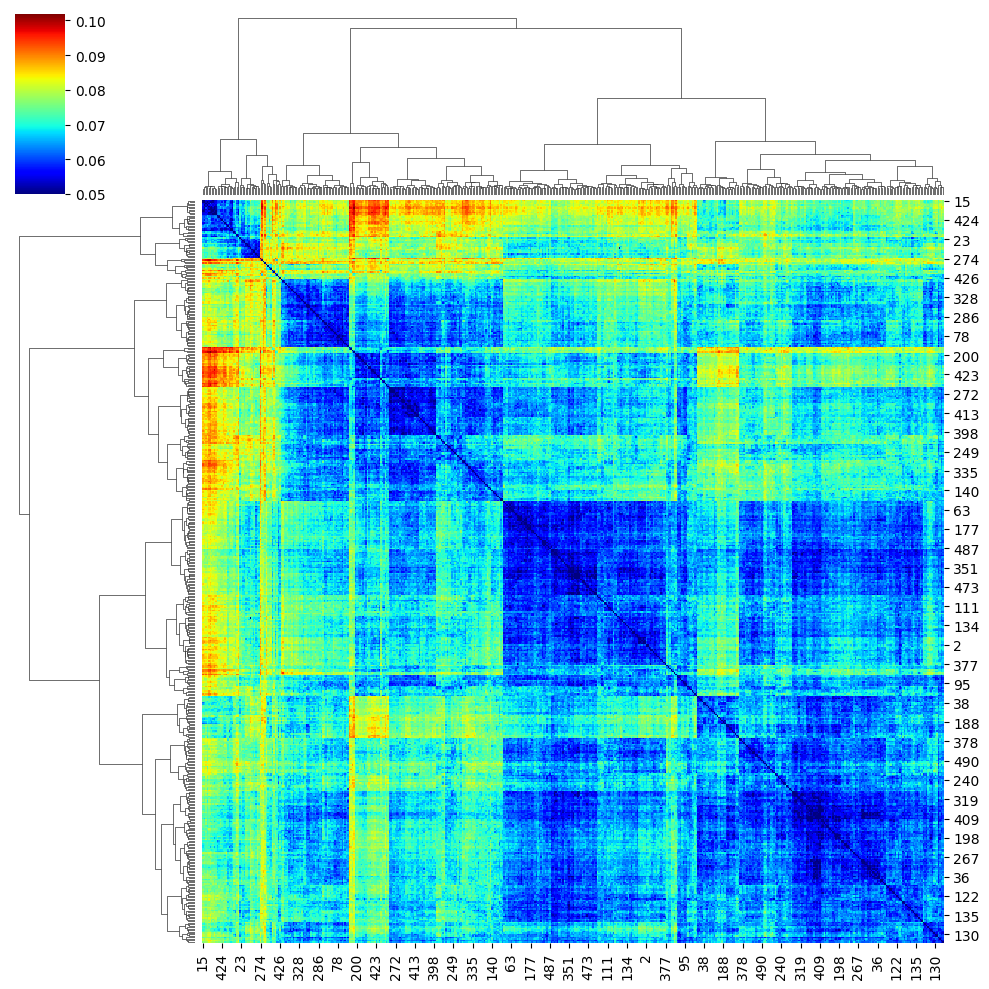

In [9]:
sns.clustermap(H,method='ward',cmap='jet',vmin=0.05)

In [10]:
NULL=np.array(['']*len(model.feature_names))

In [11]:
qs=qsample(NULL,model,50)

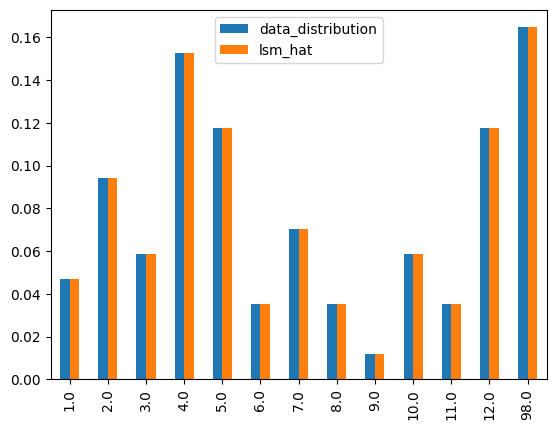

In [12]:
k=300 # choose the index
varname = model.feature_names[k]
P=model.predict_distributions(qs)
B=pd.DataFrame(P[k],index=['lsm_hat']).T
B.index=B.index.values.astype(float)
B=B.sort_index()

A=pd.DataFrame(df.head(5000)[varname].value_counts())
A.columns=['data_distribution']
A.index.name=None
A=A.drop('')
A.index=A.index.values.astype(float)

A=A/A.sum()
A=A.sort_index()
A=A.join(B).fillna(0)
ax=A.plot(kind='bar')
#B.plot(kind='bar',ax=ax,color='r',alpha=.5)


In [13]:
def max_keys(dict_list, tie="first"):
    """Return list of keys with maximum values for each dict; robust to empties."""
    out = []
    for d in dict_list:
        if not d:
            out.append(None)
            continue
        if tie == "first":
            out.append(max(d, key=d.get))
        elif tie == "all":
            m = max(d.values())
            out.append(tuple(k for k, v in d.items() if v == m))
        else:
            raise ValueError("tie must be 'first' or 'all'")
    return out

def compute_and_save_snull(model, out_path="snull.csv", tie="first"):
    """
    Compute snull = argmax key of each predicted distribution at NULL,
    save as a DataFrame with feature names, and return the DataFrame.

    Parameters
    ----------
    model    : loaded QNet model with .feature_names and .predict_distributions
    out_path : file path for CSV (or .parquet / .feather supported via suffix)
    tie      : {'first','all'} handling for ties in argmax

    Returns
    -------
    pd.DataFrame with columns: ['feature', 'snull']
    """
    NULL = np.array([''] * len(model.feature_names), dtype='U10')
    P = model.predict_distributions(NULL)            # list/array of dicts
    snull = max_keys(P, tie=tie)
    df = pd.DataFrame({
        "feature": list(model.feature_names),
        "snull": snull
    })

    # Save by extension
    if out_path.endswith(".csv"):
        df.to_csv(out_path, index=False)
    elif out_path.endswith(".parquet"):
        df.to_parquet(out_path, index=False)
    elif out_path.endswith(".feather"):
        df.to_feather(out_path)
    else:
        # default to CSV if unknown extension
        df.to_csv(out_path, index=False)

    return df
    

In [14]:
nulldf=compute_and_save_snull(model, out_path="snull.csv", tie="first").set_index('feature')

In [15]:
snull=nulldf.T.values[0].astype(str)
snull

array(['5.0', '2.0', '2.0', ..., '12.0', '1500.0', '18000.0'],
      shape=(4881,), dtype='<U12')

In [16]:
from tqdm import tqdm
steps=10000
Xgen=np.array([qsample(snull,model,steps) for i in tqdm(range(100))])

100%|█████████████████████████████████████████| 100/100 [08:38<00:00,  5.18s/it]


In [17]:
qsample(snull,model,steps)

array(['3.0', '2.0', '2.0', ..., '12.0', '899.0', '18000.0'],
      shape=(4881,), dtype='<U12')

In [18]:
Xgen

array([['2.0', '2.0', '1.0', ..., '12.0', '586.0', '14400.0'],
       ['2.0', '2.0', '3.0', ..., '12.0', '1500.0', '13680.0'],
       ['5.0', '1.0', '2.0', ..., '12.0', '950.0', '18000.0'],
       ...,
       ['9.0', '2.0', '3.0', ..., '12.0', '950.0', '18000.0'],
       ['3.0', '2.0', '2.0', ..., '12.0', '1293.0', '23736.0'],
       ['5.0', '2.0', '3.0', ..., '12.0', '726.0', '20364.0']],
      shape=(100, 4881), dtype='<U12')

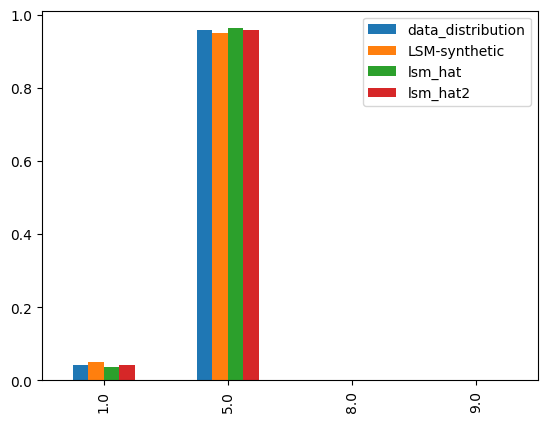

In [25]:
k=200 # choose the index
varname = model.feature_names[k]

df1=df.copy()#[df[varname0]==2.0]
A=pd.DataFrame(df1.head(5000)[varname].value_counts())
A.columns=['data_distribution']
A.index.name=None
A=A.drop('')
A.index=A.index.values.astype(float)
A=A/A.sum()
A=A.sort_index()

Ag=pd.DataFrame(Xgen,columns=model.feature_names)
Ag1=Ag.copy()#[Ag[varname0]=='2.0']
Y=pd.DataFrame(Ag1[varname].value_counts())
Y.columns=['LSM-synthetic']
Y.index.name=None
#Y=Y.drop('')
Y.index=Y.index.values.astype(float)
Y=Y/Y.sum()
Y=Y.sort_index()

qs1=snull.copy()
steps=10000
qs=qsample(qs1,model,steps)
P=model.predict_distributions(qs)
B=pd.DataFrame(P[k],index=['lsm_hat']).T
B.index=B.index.values.astype(float)
B=B.sort_index()

qs1=NULL.copy()
steps=10000
qs=qsample(qs1,model,steps)
P=model.predict_distributions(qs)
C=pd.DataFrame(P[k],index=['lsm_hat2']).T
C.index=C.index.values.astype(float)
C=C.sort_index()


A=A.join(Y).join(B).join(C).fillna(0)
ax=A.plot(kind='bar')

In [20]:
dfs=df.astype(str)

In [21]:
dfs.replace('',np.nan).dropna()#.corr()

,PVDATE,PB084,PB000,PB132,PB002,PB003M,PB006,PB085,PB086,PB087,...,PQR066R,PQP066R,PQR076R,PQP076R,PQR085M,PQR085R,PQR085A,PQP085M,PQP085R,PQP085A


In [22]:
Xf=pd.DataFrame(Xgen,columns=model.feature_names)

In [23]:
df

,PVDATE,PB084,PB000,PB132,PB002,PB003M,PB006,PB085,PB086,PB087,...,PQR066R,PQP066R,PQR076R,PQP076R,PQR085M,PQR085R,PQR085A,PQP085M,PQP085R,PQP085A
0,3.0,1.0,2.0,8.0,,,,,,,...,,,,,12.0,875.5,10800.0,,,
1,3.0,1.0,1.0,9.0,,,,,,,...,,,,,12.0,1800.0,21510.0,,,
2,2.0,1.0,3.0,6.0,,,,,,,...,,,,,12.0,1100.0,13200.0,,,
3,2.0,1.0,2.0,8.0,,,,,,,...,,,,,12.0,1956.0,23394.0,12.0,1500.0,18000.0
4,2.0,1.0,2.0,7.0,,,,,,,...,,,,,12.0,1500.0,18000.0,12.0,1977.0,23736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,9.0,2.0,3.0,0.0,,,,,,,...,,,,,12.0,1100.0,13200.0,,,
9968,5.0,1.0,2.0,0.0,,,,,,,...,,,,,12.0,,,12.0,,
9969,5.0,1.0,2.0,4.0,,,,,,,...,,,,,12.0,,,12.0,,
9970,8.0,1.0,4.0,0.0,,,,,,,...,,,,,12.0,700.0,8184.0,,,


In [24]:
len(model.feature_names)

4881